In [1]:
# | default_exp attention

%load_ext autoreload
%autoreload 2

%env TOKENIZERS_PARALLELISM=false
%env PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

env: TOKENIZERS_PARALLELISM=false
env: PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import uuid
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import datetime
from icecream import ic
import math
from my_transformer.utils import save_model, load_model
from transformers import AutoTokenizer

from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
import json
import os
from rich import print

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Dataset

In [3]:
df = pd.read_csv("../dataset/bob_dylan_lyrics.csv")
lines = []
nb_rows = 999999
row_id = 0
for r in df.iterrows():
    # todo: one line is one sentence.
    lines.append(r[1]["title"])
    # sentences.append(r[1]["title"] + "\n" + r[1]["lyrics"])
    lyrics = r[1]["lyrics"].split("\n")
    for line in lyrics:
        if len(line.strip()) > 0:
            lines.append(line.strip())
        row_id += 1

lines[:10], len(lines)

(['Hard Times In New York Town',
  'Come you ladies and you gentlemen, a-listen to my song',
  'Sing it to you right, but you might think it’s wrong',
  'Just a little glimpse of a story I’ll tell',
  '’Bout an East Coast city that you all know well',
  'It’s hard times in the city',
  'Livin’ down in New York town',
  'Old New York City is a friendly old town',
  'From Washington Heights to Harlem on down',
  'There’s a-mighty many people all millin’ all around'],
 14318)

### Simple Custom Tokenizer for Bob Dylan Lyrics

Create a simple BPE (Byte-Pair Encoding) tokenizer trained specifically on Dylan's lyrics.


In [4]:
class SimpleDylanTokenizer:
    def __init__(self, vocab_size=3000):
        self.vocab_size = vocab_size
        self.tokenizer = None

    def train_tokenizer(self, corpus: list[str], save_path: str = "./simple_dylan_tokenizer"):
        # Initialize simple BPE tokenizer
        tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

        # Simple whitespace pre-tokenization
        tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

        # Simple trainer
        trainer = BpeTrainer(
            vocab_size=self.vocab_size, special_tokens=["[PAD]", "[UNK]", "[MASK]"], min_frequency=2, show_progress=True
        )

        # Train the tokenizer
        tokenizer.train_from_iterator(corpus, trainer)

        # Save tokenizer
        os.makedirs(save_path, exist_ok=True)
        tokenizer.save(f"{save_path}/tokenizer.json")

        self.tokenizer = tokenizer
        print(f"Tokenizer trained and saved to {save_path}")

        return tokenizer

    def load_tokenizer(self, save_path="./simple_dylan_tokenizer"):
        """Load the trained tokenizer"""
        tokenizer_path = f"{save_path}/tokenizer.json"
        if os.path.exists(tokenizer_path):
            self.tokenizer = Tokenizer.from_file(tokenizer_path)
            return self.tokenizer
        else:
            raise FileNotFoundError(f"Tokenizer not found at {tokenizer_path}")

    def get_transformers_tokenizer(self):
        """Convert to HuggingFace tokenizer for compatibility"""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not trained or loaded")

        # Create fast tokenizer wrapper
        fast_tokenizer = PreTrainedTokenizerFast(
            tokenizer_object=self.tokenizer, pad_token="[PAD]", unk_token="[UNK]", mask_token="[MASK]"
        )

        return fast_tokenizer

In [5]:
# Initialize simple Dylan tokenizer
dylan_tokenizer = SimpleDylanTokenizer(vocab_size=5000)

# Train the tokenizer on Dylan lyrics
dylan_tokenizer.train_tokenizer(corpus=lines, save_path="./simple_dylan_tokenizer")

# Convert to HuggingFace format for compatibility
tokenizer = dylan_tokenizer.get_transformers_tokenizer()

ic(len(tokenizer))
ic(tokenizer.special_tokens_map)


phrase = "The answer my friend is blowin' in the wind"

tokens = tokenizer.encode(phrase, add_special_tokens=False)
decoded = tokenizer.decode(tokens, skip_special_tokens=False)
token_strs = tokenizer.convert_ids_to_tokens(tokens)
ic(phrase)
ic(decoded)
ic(token_strs);


Tokenizer trained and saved to ./simple_dylan_tokenizer

ic| len(tokenizer): 5000
ic| tokenizer.special_tokens_map: {'mask_token': '[MASK]', 'pad_token': '[PAD]', 'unk_token': '[UNK]'}
ic| phrase: "The answer my friend is blowin' in the wind"
ic| decoded: "The answer my friend is blowin ' in the wind"
ic| token_strs: ['The', 'answer', 'my', 'friend', 'is', 'blowin', "'", 'in', 'the', 'wind']


In [6]:
class SimpleDylanDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len=128):
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.examples = []
        max_seq_len = 0

        for line in texts:
            # Simple tokenization - no structure tokens
            tokens = tokenizer.encode(line.strip(), add_special_tokens=False)
            token_nb = len(tokens)
            max_seq_len = max(max_seq_len, token_nb)
            # Truncate if too long

            if token_nb > seq_len:
                tokens = tokens[:seq_len]

            if token_nb > 0:  # Skip empty sequences
                self.examples.append(tokens)
        print(f"Max sequence length in dataset: {max_seq_len}")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        tokens = self.examples[idx]
        pad_id = self.tokenizer.pad_token_id if hasattr(self.tokenizer, "pad_token_id") else 0

        # Pad to sequence length
        padded = tokens + [pad_id] * (self.seq_len - len(tokens))
        return torch.tensor(padded[: self.seq_len], dtype=torch.long)


seq_len = 20  # Keep shorter sequences for memory efficiency
batch_size = 8

# Create dataset with selected tokenizer
dataset = SimpleDylanDataset(lines, tokenizer, seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

ic(len(dataset))
ic(seq_len)
ic(len(tokenizer))

# Test the dataset
sample_batch = next(iter(dataloader))
ic(sample_batch.shape)
ic(tokenizer.decode(sample_batch[0].tolist(), skip_special_tokens=False));


Max sequence length in dataset: 40

ic| len(dataset): 14318
ic| seq_len: 20
ic| len(tokenizer): 5000
ic| sample_batch.shape: torch.Size([8, 20])
ic| tokenizer.decode(sample_batch[0].tolist(), skip_special_tokens=False): ('I ’ m gone [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] '
                                                                            '[PAD] [PAD] [PAD] [PAD] [PAD]')


## Diffusion model

In [20]:
class UniformScheduler:
    """Simple uniform transition scheduler with linear noise schedule."""

    def __init__(self, num_classes: int, num_timesteps: int, beta_start: float = 0.0001, beta_end: float = 0.02):
        self.num_classes = num_classes
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        # Create schedule and transition matrices
        self.betas = self._create_linear_schedule()
        self.Q_t = self._create_transition_matrices()
        self.Q_bar_t = self._create_cumulative_matrices()

    def _create_linear_schedule(self) -> torch.Tensor:
        """Create linear beta schedule: β_t increases linearly from beta_start to beta_end."""
        return torch.linspace(self.beta_start, self.beta_end, self.num_timesteps)

    def _create_transition_matrices(self) -> torch.Tensor:
        """
        Create uniform transition matrices: Q_t = (1-β_t)I + β_t/K * 11^T

        This means:
        - Stay in same state with probability (1-β_t)
        - Transition to any state (including same) with probability β_t/K each
        """
        Q_matrices = torch.zeros(self.num_timesteps, self.num_classes, self.num_classes)

        for t in range(self.num_timesteps):
            beta_t = self.betas[t].item()

            # Diagonal: probability of staying in same state
            Q_t = (1 - beta_t) * torch.eye(self.num_classes)

            # Off-diagonal: uniform probability of transitioning to any state
            Q_t += beta_t / self.num_classes * torch.ones(self.num_classes, self.num_classes)

            Q_matrices[t] = Q_t

        return Q_matrices

    def _create_cumulative_matrices(self) -> torch.Tensor:
        """Create cumulative matrices: Q̄_t = Q_1 * Q_2 * ... * Q_t"""
        Q_bar_matrices = torch.zeros(self.num_timesteps, self.num_classes, self.num_classes)
        Q_bar_matrices[0] = self.Q_t[0]

        for t in range(1, self.num_timesteps):
            Q_bar_matrices[t] = torch.matmul(Q_bar_matrices[t - 1], self.Q_t[t])

        return Q_bar_matrices

    def add_noise(self, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Apply forward diffusion: sample from q(x_t | x_0).

        For uniform transitions, this uses the cumulative matrix Q̄_t.
        """
        batch_size, seq_len = x_0.shape
        device = x_0.device

        # Convert to one-hot encoding
        x_0_onehot = F.one_hot(x_0, self.num_classes).float()  # [B, L, K]

        x_t = torch.zeros_like(x_0)

        for i, t_val in enumerate(t):
            # Get cumulative transition matrix for this timestep
            Q_bar = self.Q_bar_t[t_val].to(device)  # [K, K]

            # Compute transition probabilities: x_0 @ Q̄_t
            # This gives probability distribution over x_t for each position
            probs = torch.matmul(x_0_onehot[i], Q_bar)  # [L, K]

            # Sample from categorical distribution
            flat_probs = probs.view(-1, self.num_classes)  # [L, K]
            flat_samples = torch.multinomial(flat_probs, 1).squeeze(-1)  # [L]
            x_t[i] = flat_samples

        return x_t

    def get_posterior_params(self, x_t: torch.Tensor, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute true posterior q(x_{t-1} | x_t, x_0) using Equation 3.

        From the paper: q(x_{t-1}|x_t,x_0) = Cat(x_{t-1}; p = x_t Q_t^T ⊙ x_0 Q̄_{t-1} / (x_0 Q̄_t x_t^T))

        This tells us: given we observe x_t at time t and know the original was x_0,
        what's the probability distribution over what x_{t-1} could have been?
        """
        batch_size, seq_len = x_t.shape
        device = x_t.device

        posteriors = torch.zeros(batch_size, seq_len, self.num_classes, device=device)

        for i, t_val in enumerate(t):
            if t_val == 0:
                # Special case: t=0 means we're asking for q(x_{-1}|x_0, x_0)
                # This doesn't make physical sense, so return uniform or x_0
                # In practice, this case shouldn't occur in training
                posteriors[i] = F.one_hot(x_0[i], self.num_classes).float()
                continue

            # Get transition matrices
            Q_t = self.Q_t[t_val].to(device)  # [K, K] - single step t
            Q_bar_t_minus_1 = self.Q_bar_t[t_val - 1].to(device)  # [K, K] - cumulative to t-1
            Q_bar_t = self.Q_bar_t[t_val].to(device)  # [K, K] - cumulative to t

            # For each position in sequence
            for pos in range(seq_len):
                x_0_idx = x_0[i, pos].item()  # Original token index
                x_t_idx = x_t[i, pos].item()  # Current token index

                # Compute posterior using Bayes rule:
                # q(x_{t-1}|x_t,x_0) ∝ q(x_t|x_{t-1},x_0) * q(x_{t-1}|x_0)
                #                    = q(x_t|x_{t-1}) * q(x_{t-1}|x_0)  [Markov property]

                posterior = torch.zeros(self.num_classes, device=device)

                # For each possible value of x_{t-1}
                for x_prev_idx in range(self.num_classes):
                    # q(x_{t-1}|x_0): probability that x_{t-1} = x_prev_idx given x_0
                    q_prev_given_x0 = Q_bar_t_minus_1[x_0_idx, x_prev_idx]

                    # q(x_t|x_{t-1}): probability that x_t = x_t_idx given x_{t-1} = x_prev_idx
                    q_curr_given_prev = Q_t[x_prev_idx, x_t_idx]

                    # Joint probability
                    posterior[x_prev_idx] = q_curr_given_prev * q_prev_given_x0

                # Normalize to get proper probability distribution
                posterior_sum = posterior.sum()
                if posterior_sum > 1e-8:
                    posterior = posterior / posterior_sum
                else:
                    # Fallback to uniform if numerical issues
                    posterior = torch.ones(self.num_classes, device=device) / self.num_classes

                posteriors[i, pos] = posterior

        return posteriors

    def compute_kl_divergence(self, true_posterior: torch.Tensor, pred_posterior: torch.Tensor) -> torch.Tensor:
        """Compute KL[q(x_{t-1}|x_t,x_0) || p_θ(x_{t-1}|x_t)]"""
        kl = torch.sum(true_posterior * (torch.log(true_posterior + 1e-8) - torch.log(pred_posterior + 1e-8)), dim=-1)
        return kl

In [30]:
scheduler = UniformScheduler(num_classes=100, num_timesteps=1000)

x_0 = torch.tensor([[42, 15, 73]])  # Original tokens

# Check at different timesteps
for t_val in [1, 10, 50, 100, 500]:
    t = torch.tensor([t_val])
    x_t = scheduler.add_noise(x_0, t)

    true_posterior = scheduler.get_posterior_params(x_t, x_0, t)
    true_prev = true_posterior.argmax(dim=-1)

    print(
        f"t={t_val}: x_0: {x_0[0].tolist()}, x_t: {x_t[0].tolist()}, true x_{{t-1}}: {true_prev[0].tolist()},\nequals x_0: {true_prev[0].equal(x_0[0])}"
    )


t=1: x_0: [42, 15, 73], x_t: [42, 15, 73], true x_{t-1}: [42, 15, 73],
equals x_0: True

t=10: x_0: [42, 15, 73], x_t: [42, 15, 73], true x_{t-1}: [42, 15, 73],
equals x_0: True

t=50: x_0: [42, 15, 73], x_t: [42, 15, 73], true x_{t-1}: [42, 15, 73],
equals x_0: True

t=100: x_0: [42, 15, 73], x_t: [42, 15, 48], true x_{t-1}: [42, 15, 48],
equals x_0: False

t=500: x_0: [42, 15, 73], x_t: [20, 15, 3], true x_{t-1}: [20, 15, 3],
equals x_0: False

In [44]:
"""Test that posterior evolves correctly as we move through timesteps."""
print("Testing posterior evolution...")

vocab_size = 5  # Very small for clear visualization
scheduler = UniformScheduler(num_classes=vocab_size, num_timesteps=10, beta_start=0.1, beta_end=0.9)

x_0 = torch.tensor([[1]])  # Single token, original = 1

print("Evolution of posterior q(x_{t-1} | x_t, x_0) as t increases:")
print("(Shows probability of each token being x_{t-1})")
print()

for t_val in range(1, 6):
    t = torch.tensor([t_val])
    x_t = scheduler.add_noise(x_0, t)
    posterior = scheduler.get_posterior_params(x_t, x_0, t)
    true_prev = posterior.argmax(dim=-1)

    print(
        f"t={t_val}, x_0=1, x_t={x_t[0, 0].item()},  P(x_{{t-1}} = k): {[f'{p:.3f}' for p in posterior[0, 0].tolist()]},Most likely x_{{t-1}}: {posterior[0, 0].argmax().item()}"
    )


Testing posterior evolution...

Evolution of posterior q(x_{t-1} | x_t, x_0) as t increases:

(Shows probability of each token being x_{t-1})

t=1, x_0=1, x_t=2,  P(x_{t-1} = k): ['0.014', '0.644', '0.314', '0.014', '0.014'],Most likely x_{t-1}: 1

t=2, x_0=1, x_t=0,  P(x_{t-1} = k): ['0.444', '0.461', '0.032', '0.032', '0.032'],Most likely x_{t-1}: 1

t=3, x_0=1, x_t=4,  P(x_{t-1} = k): ['0.052', '0.342', '0.052', '0.052', '0.502'],Most likely x_{t-1}: 4

t=4, x_0=1, x_t=1,  P(x_{t-1} = k): ['0.035', '0.859', '0.035', '0.035', '0.035'],Most likely x_{t-1}: 1

t=5, x_0=1, x_t=1,  P(x_{t-1} = k): ['0.067', '0.732', '0.067', '0.067', '0.067'],Most likely x_{t-1}: 1

In [ ]:
# Generate some noisy sentences
inp = next(iter(dataloader)).to(device)
ic(inp.shape)

ds_scheduler = UniformScheduler(num_classes=len(tokenizer), num_timesteps=30)


def demo_noise(inp, line_nb, step):
    src_line = tokenizer.decode(inp[line_nb].cpu().numpy())
    noisy_inp = ds_scheduler.add_noise(inp[line_nb : line_nb + 1], torch.tensor([step]).to(device))
    noisy_line = tokenizer.decode(noisy_inp[0].cpu().numpy())
    return src_line, noisy_line


ic.disable()
ic.enable()
sent_nb = 4
print(demo_noise(inp, sent_nb, 0)[1])
print(demo_noise(inp, sent_nb, 12)[1])
print(demo_noise(inp, sent_nb, 20)[1])
print(demo_noise(inp, sent_nb, 29)[1])


ic| inp.shape: torch.Size([8, 20])


Ya know I just couldn ’ t make it by myself [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Ya know I just couldn ill t make it by myself [PAD] [PAD] aist [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Ya blues Ke just couldn ’ t make it by myself watered [PAD] [PAD] [PAD] [PAD] mankind [PAD] [PAD] beer

swall know sight Señor ched ’ t army it by stories [PAD] [PAD] nob [PAD] [PAD] [PAD] [PAD] Reed [PAD]

In [45]:
class SimpleD3PMModel(nn.Module):
    """Simple transformer model for D3PM."""

    def __init__(
        self,
        vocab_size: int,
        max_seq_len: int,
        d_model: int = 256,
        num_heads: int = 8,
        num_layers: int = 4,
        dropout: float = 0.1,
    ):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model

        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)

        # Time embedding for diffusion timestep
        self.time_embedding = nn.Sequential(nn.Linear(d_model, d_model), nn.GELU(), nn.Linear(d_model, d_model))

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Output head to predict x₀
        self.output_head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, vocab_size))

        self.dropout = nn.Dropout(dropout)

    def _get_time_embedding(self, t: torch.Tensor) -> torch.Tensor:
        """Create sinusoidal time embeddings like in original Transformer."""
        half_dim = self.d_model // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device, dtype=torch.float32) * -emb)
        emb = t.float()[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

        if self.d_model % 2 == 1:  # Handle odd d_model
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)

        return self.time_embedding(emb)

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: predict x₀ from x_t.

        Args:
            x_t: Noisy tokens, shape [batch_size, seq_len]
            t: Timesteps, shape [batch_size]

        Returns:
            x0_logits: Predicted x₀ logits, shape [batch_size, seq_len, vocab_size]
        """
        batch_size, seq_len = x_t.shape
        device = x_t.device

        # Token embeddings
        token_emb = self.token_embedding(x_t)  # [B, L, D]

        # Position embeddings
        positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
        pos_emb = self.position_embedding(positions)  # [B, L, D]

        # Time embeddings
        time_emb = self._get_time_embedding(t)  # [B, D]
        time_emb = time_emb.unsqueeze(1).expand(-1, seq_len, -1)  # [B, L, D]

        # Combine all embeddings
        x = self.dropout(token_emb + pos_emb + time_emb)  # [B, L, D]

        # Transformer processing
        x = self.transformer(x)  # [B, L, D]

        # Predict x₀ logits
        x0_logits = self.output_head(x)  # [B, L, vocab_size]

        return x0_logits


In [56]:
def compute_predicted_posterior(
    scheduler: UniformScheduler, x0_logits: torch.Tensor, x_t: torch.Tensor, t: torch.Tensor
) -> torch.Tensor:
    """
    Compute p_θ(x_{t-1}|x_t) using x₀-parameterization.

    From Equation 4: p_θ(x_{t-1}|x_t) ∝ Σ q(x_{t-1},x_t|x̃₀) p̃_θ(x̃₀|x_t)
    """
    batch_size, seq_len = x_t.shape
    device = x_t.device

    # Convert model logits to probabilities
    p_x0_given_xt = F.softmax(x0_logits, dim=-1)  # [B, L, K]

    pred_posteriors = torch.zeros(batch_size, seq_len, scheduler.num_classes, device=device)

    for i, t_val in enumerate(t):
        if t_val == 0:
            # At t=0, just return the x₀ prediction
            pred_posteriors[i] = p_x0_given_xt[i]
            continue

        # Get transition matrix Q_t
        Q_t = scheduler.Q_t[t_val].to(device)  # [K, K]

        # For each position, marginalize over possible x₀ values
        for pos in range(seq_len):
            p_x0_pos = p_x0_given_xt[i, pos]  # [K] - predicted x₀ distribution

            # Get current token
            x_t_pos = x_t[i, pos].item()

            # Marginalize: p_θ(x_{t-1}|x_t) = Σ p(x_{t-1}|x_t,x₀) p_θ(x₀|x_t)
            pred_posterior = torch.zeros(scheduler.num_classes, device=device)

            for x0_idx in range(scheduler.num_classes):
                # Weight by predicted probability of this x₀
                weight = p_x0_pos[x0_idx]

                # For this x₀, what's p(x_{t-1}|x_t,x₀)?
                # This is like the true posterior but conditioned on specific x₀

                # Simplified: if x₀ was token k, then x_{t-1} was likely k
                # (since uniform transitions are symmetric)
                for x_prev in range(scheduler.num_classes):
                    # Probability that x_{t-1}=x_prev leads to x_t given x₀=x0_idx
                    prob_prev_to_curr = Q_t[x_prev, x_t_pos]
                    pred_posterior[x_prev] += weight * prob_prev_to_curr

            # Normalize
            pred_posterior = pred_posterior / (pred_posterior.sum() + 1e-8)
            pred_posteriors[i, pos] = pred_posterior

    return pred_posteriors


In [62]:
""" Training step on a single batch. """


def training_step(
    scheduler: UniformScheduler, model: SimpleD3PMModel, x_0: torch.Tensor, t: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    x_t = scheduler.add_noise(x_0, t)
    x0_logits = model(x_t, t)
    ic(x0_logits.shape)
    true_posterior = scheduler.get_posterior_params(x_t, x_0, t)
    ic(true_posterior.shape)
    pred_posterior = compute_predicted_posterior(scheduler=scheduler, x0_logits=x0_logits, x_t=x_t, t=t)
    ic(pred_posterior.shape)

    kl_terms = scheduler.compute_kl_divergence(true_posterior, pred_posterior)
    ic(kl_terms.shape)
    return x0_logits, kl_terms


scheduler = UniformScheduler(num_classes=100, num_timesteps=10, beta_start=0.1, beta_end=0.9)
x_0 = torch.tensor([[42, 15, 73]])
model = SimpleD3PMModel(vocab_size=100, max_seq_len=10, d_model=64, num_heads=1, num_layers=1)
t = torch.tensor([3])

x0_logits, kl_terms = training_step(scheduler, model, x_0, t)


/Users/jkunz/Projects/transformer_implementations/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
ic| x0_logits.shape: torch.Size([1, 3, 100])
ic| true_posterior.shape: torch.Size([1, 3, 100])
ic| pred_posterior.shape: torch.Size([1, 3, 100])
ic| kl_terms.shape: torch.Size([1, 3])


In [ ]:
# Cross entropy loss computation

x_0 = torch.tensor([[0, 1, 2], [2, 1, 0]]).long().to(device)  # Use long for indices
# preds are logits
pred_logit = (
    torch.tensor(
        [
            [[1000, 0, 0], [0, 1000, 0], [0, 0, 1000]],
            [[0, 0, 1000], [0, 1000, 0], [1000, 0, 0]],
        ]
    )
    .float()
    .to(device)
)

# For cross-entropy, pred needs to be reshaped to [batch*seq, num_classes]
ic(F.cross_entropy(pred_logit.view(-1, 3), x_0.view(-1), reduction="mean"))

# For the manual computation, convert x_0 to one-hot encoding
psm = F.softmax(pred_logit, dim=-1)  # Apply softmax over the last dimension (classes)
ic(psm, psm.shape)

# Convert x_0 to one-hot encoding
x_0_onehot = F.one_hot(x_0, num_classes=3).float()  # Shape: [2, 3, 3]
ic(x_0_onehot, x_0_onehot.shape)

# Now compute the negative log likelihood
neg_log_likelihood = -torch.sum(x_0_onehot * torch.log(psm + 1e-10), dim=-1)
ic(neg_log_likelihood, neg_log_likelihood.shape)
ic(neg_log_likelihood.mean())  # Mean over the sequence length

ic| F.cross_entropy(pred.view(-1, 3), x_0.view(-1), reduction="mean"): tensor(0., device='mps:0')
| F.cross_entropy(pred.view(-1, 3), x_0.view(-1), reduction="mean"): tensor(0., device='mps:0')
ic| psm: tensor([[[1., 0., 0.],
                  [0., 1., 0.],
                  [0., 0., 1.]],ic| psm: tensor([[[1., 0., 0.],
                  [0., 1., 0.],
                  [0., 0., 1.]],
         
                 [[0., 0., 1.],

         
                 [[0., 0., 1.],
                  [0., 1., 0.],
                  [1., 0., 0.]]], device='mps:0')
    psm.shape: torch.Size([2, 3, 3]                  [0., 1., 0.],
                  [1., 0., 0.]]], device='mps:0')
    psm.shape: torch.Size([2, 3, 3])
)
ic| x_0_onehot: tensor([[[1., 0., 0.],
                         ic| x_0_onehot: tensor([[[1., 0., 0.],
                         [0., 1., 0.],
                         [0., 0., 1.]],
                
                        [[0., 0., 1.],
                         [0., 1.,[0., 1., 0.],
     

tensor(0., device='mps:0')

In [34]:
# Dummy data
num_classes = 10
num_timesteps = 5
batch_size = 2
seq_len = 3
x_0 = torch.randint(0, num_classes, (batch_size, seq_len))  # Clean data
x_t = torch.randint(0, num_classes, (batch_size, seq_len))  # Noisy data
t = torch.randint(0, num_timesteps, (batch_size,))  # Timesteps

# Model prediction (logits for p̃_θ(x̃_0|x_t))
model_logits = torch.randn(batch_size, seq_len, num_classes)
ic(model_logits.shape)

ic| model_logits.shape: torch.Size([2, 3, 10])
| model_logits.shape: torch.Size([2, 3, 10])


torch.Size([2, 3, 10])

In [ ]:
from typing import Optional


class D3PMLoss(nn.Module):
    """
    D3PM Loss Function: L_λ = L_vb + λ * auxiliary_loss

    Implements the hybrid loss from Equation 5 in the D3PM paper.
    This is a simplified version that expects the model to handle
    the complex posterior computations.
    """

    def __init__(self, lambda_weight: float = 0.001, use_auxiliary_loss: bool = True):
        super().__init__()

        self.lambda_weight = lambda_weight
        self.use_auxiliary_loss = use_auxiliary_loss

    def forward(
        self,
        model_x0_logits: torch.Tensor,  # Model's prediction of p̃_θ(x̃_0|x_t)
        model_kl_terms: torch.Tensor,  # Pre-computed KL divergence terms
        x_0: torch.Tensor,  # Original clean data
        t: torch.Tensor,  # Timesteps
        mask: Optional[torch.Tensor] = None,
    ) -> tuple[torch.Tensor, dict]:
        """
        Compute D3PM loss.

        Args:
            model_x0_logits: Model's logits for p̃_θ(x̃_0|x_t), shape [B, ..., K]
            model_kl_terms: Pre-computed KL terms from model, shape [B, ...]
            x_0: Clean data for auxiliary loss, shape [B, ...]
            t: Timesteps, shape [B]
            mask: Optional mask for sequence padding, shape [B, ...]

        Returns:
            loss: Total loss scalar
            loss_dict: Dictionary with loss components
        """

        # 1. Auxiliary loss: E[-log p̃_θ(x_0|x_t)]
        auxiliary_loss = self._compute_auxiliary_loss(model_x0_logits, x_0, mask)

        # 2. Variational bound loss: Use pre-computed KL terms from model
        vb_loss = model_kl_terms.mean()

        # 3. Combine losses
        if self.use_auxiliary_loss:
            total_loss = vb_loss + self.lambda_weight * auxiliary_loss
        else:
            total_loss = vb_loss

        loss_dict = {
            "total_loss": total_loss,
            "vb_loss": vb_loss,
            "auxiliary_loss": auxiliary_loss,
            "weighted_auxiliary": self.lambda_weight * auxiliary_loss,
        }

        return total_loss, loss_dict

    def _compute_auxiliary_loss(
        self,
        model_logits: torch.Tensor,  # [B, ..., K]
        x_0: torch.Tensor,  # [B, ...]
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """
        Compute auxiliary denoising loss: -log p̃_θ(x_0|x_t)
        """
        # Flatten all but last dimension for cross entropy
        flat_logits = model_logits.view(-1, model_logits.size(-1))  # [B*N, K]
        flat_targets = x_0.view(-1).long()  # [B*N]

        # Compute cross entropy loss
        ce_loss = F.cross_entropy(flat_logits, flat_targets, reduction="none")  # [B*N]

        if mask is not None:
            flat_mask = mask.view(-1).float()  # [B*N]
            ce_loss = ce_loss * flat_mask
            return ce_loss.sum() / (flat_mask.sum() + 1e-8)
        else:
            return ce_loss.mean()

In [8]:
class D3pmDiffusion(nn.Module):
    """Implementation of uniform transition with linear beta schedule"""

    def __init__(
        self, num_discrete_states: int, num_timesteps: int = 1000, beta_start: float = 0.0001, beta_end: float = 0.02
    ):
        super().__init__()
        self.num_discrete_states = num_discrete_states
        self.num_timesteps = num_timesteps

        # More conservative beta schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

        # Precompute transition matrices
        self.transition_matrices_t = nn.ParameterList()
        self.cumulative_transition_matrices_t = nn.ParameterList()

        Q_prev_cumulative = torch.eye(num_discrete_states)

        for t in range(num_timesteps):
            beta = self.betas[t].item()

            # More conservative transition matrix
            diag_prob = 1.0 - beta
            off_diag_prob = beta / (num_discrete_states - 1) if num_discrete_states > 1 else 0.0

            Q_t = torch.eye(num_discrete_states) * diag_prob
            Q_t = (
                Q_t
                + (torch.ones(num_discrete_states, num_discrete_states) - torch.eye(num_discrete_states))
                * off_diag_prob
            )
            Q_t = Q_t / Q_t.sum(dim=1, keepdim=True)

            self.transition_matrices_t.append(nn.Parameter(Q_t, requires_grad=False))

            Q_current_cumulative = torch.matmul(Q_t, Q_prev_cumulative)
            self.cumulative_transition_matrices_t.append(nn.Parameter(Q_current_cumulative, requires_grad=False))
            Q_prev_cumulative = Q_current_cumulative

    def forward(self, x_0: torch.Tensor, t: torch.Tensor):
        """Forward diffusion process"""
        original_shape = x_0.shape
        batch_size = original_shape[0]
        x_flat = x_0.view(batch_size, -1)
        num_elements = x_flat.shape[1]

        # Convert to one-hot encoding
        x_one_hot = F.one_hot(x_flat, num_classes=self.num_discrete_states).float()

        # Gather transition matrices for batch
        Q_bar_t_batch = torch.stack([self.cumulative_transition_matrices_t[idx] for idx in t])

        # Apply transition
        next_state_probs = torch.bmm(x_one_hot, Q_bar_t_batch)

        # Sample from categorical distribution
        x_t = torch.multinomial(next_state_probs.view(-1, self.num_discrete_states), num_samples=1).squeeze(dim=1)
        x_t = x_t.view(original_shape)

        return x_t

    def compute_loss(self, x_0: torch.Tensor, predicted_logits: torch.Tensor, t: torch.Tensor, pad_token_id: int = 0):
        """Compute proper D3PM loss with padding mask"""
        batch_size, seq_len = x_0.shape

        # Create padding mask
        pad_mask = (x_0 != pad_token_id).float()  # 1 for real tokens, 0 for padding

        # Compute cross-entropy loss
        ic(predicted_logits.view(-1, self.num_discrete_states).shape)
        ic(x_0.view(-1).shape)
        loss = F.cross_entropy(predicted_logits.view(-1, self.num_discrete_states), x_0.view(-1), reduction="none")

        # Apply padding mask
        loss = loss.view(batch_size, seq_len)
        masked_loss = loss * pad_mask

        # Average over non-padded tokens
        total_loss = masked_loss.sum() / pad_mask.sum().clamp(min=1)

        return total_loss


# Define parameters
NUM_STATES = len(tokenizer)  # e.g., pixel values 0, 1, 2, 3
NUM_CLASSES = len(tokenizer)  # Number of discrete states (e.g., vocabulary size)
BETA_PER_STEP = 0.2  # Probability of changing state at each step
NUM_TIMESTEPS = 2  # Number of diffusion steps
# Create the forward diffusion module
forward_diffuser = D3pmDiffusion(num_discrete_states=NUM_CLASSES, num_timesteps=NUM_TIMESTEPS).to(device)
# x_0 = torch.tensor([[0, 1, 2], [2, 1, 0]]).to(device)
# pred = torch.tensor([[[1, 0, 0], [0, 1, 0], [0, 0, 1]], [[0, 0, 1], [0, 1, 0], [1, 0, 0]]]).to(device)
# forward_diffuser.compute_loss(x_0, pred, torch.tensor([0]).to(device), pad_token_id=0)

In [11]:
inp = next(iter(dataloader)).to(device)

F.one_hot(inp, num_classes=len(tokenizer)).float()


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0., 

In [12]:
inp = next(iter(dataloader)).to(device)
ic(inp.shape)


def demo_noise(inp, line_nb, step):
    src_line = tokenizer.decode(inp[line_nb].cpu().numpy())
    noisy_inp = forward_diffuser.forward(inp[line_nb : line_nb + 1], torch.tensor([step]).to(device))
    noisy_line = tokenizer.decode(noisy_inp[0].cpu().numpy())
    return src_line, noisy_line


ic.disable()
ic.enable()
sent_nb = 4
print(demo_noise(inp, sent_nb, 0)[1])
print(demo_noise(inp, sent_nb, 12)[1])
print(demo_noise(inp, sent_nb, 20)[1])
# print(demo_noise(inp, sent_nb, 99)[1])

forward_diffuser.compute_loss(
    inp,
    F.one_hot(inp, num_classes=len(tokenizer)).float(),
    torch.tensor([0]).to(device),
    pad_token_id=tokenizer.pad_token_id,
)


ic| inp.shape: torch.Size([8, 20])


Just you and me [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


IndexError: index 12 is out of range

In [35]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.lin = nn.Linear(dim, dim)

    def forward(self, t):
        half = self.lin.in_features // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half, dtype=torch.float32) / half).to(t.device)
        args = t[:, None].float() * freqs[None]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.lin(emb)


class DiffusionTransformer(nn.Module):
    def __init__(self, vocab_size, seq_len, dim=512, heads=8, layers=6):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, dim)
        self.pos_emb = nn.Embedding(seq_len, dim)
        self.time_emb = TimeEmbedding(dim)
        enc_layer = nn.TransformerEncoderLayer(dim, heads, dim * 4)
        self.transformer = nn.TransformerEncoder(enc_layer, layers)
        self.to_logits = nn.Linear(dim, vocab_size)
        self.seq_len = seq_len

    def forward(self, x, t):
        B, L = x.shape
        tok = self.token_emb(x)
        pos = self.pos_emb(torch.arange(L, device=x.device))
        temb = self.time_emb(t).unsqueeze(1)
        h = tok + pos + temb
        h = self.transformer(h.transpose(0, 1)).transpose(0, 1)
        return self.to_logits(h)

In [47]:
import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
import os

# Hyperparameters
seq_len = 20
batch_size = 32
num_epochs = 1  # 30
learning_rate = 1e-4
weight_decay = 1e-5  # Added weight decay
vocab_size = tokenizer.vocab_size
num_timesteps = 100

# Create dataset and dataloader
dataset = SimpleDylanDataset(lines, tokenizer, seq_len=seq_len)
dataset = SimpleDylanDataset(lines[:100], tokenizer, seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate models
diffuser = D3pmDiffusion(num_discrete_states=vocab_size, num_timesteps=num_timesteps).to(device)
model = DiffusionTransformer(vocab_size=vocab_size, seq_len=seq_len).to(device)

# Enhanced optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Adaptive learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2, eta_min=1e-6)
# Alternative: ReduceLROnPlateau for validation-based scheduling
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


Max sequence length in dataset: 40
Max sequence length in dataset: 20


/Users/jkunz/Projects/transformer_implementations/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TensorBoard logs will be saved to: ../runs/d3pm_training_20250607_185216
To view logs, run: tensorboard --logdir ../runs/d3pm_training_20250607_185216

Starting enhanced training loop...
Model parameters: 24,312,200


Epoch 1/1:   0%|          | 0/4 [00:00<?, ?it/s]

ic| predicted_logits.view(-1, self.num_discrete_states).shape: torch.Size([640, 5000])
ic| x_0.view(-1).shape: torch.Size([640])
ic| predicted_logits.view(-1, self.num_discrete_states).shape: torch.Size([640, 5000])
ic| x_0.view(-1).shape: torch.Size([640])
ic| predicted_logits.view(-1, self.num_discrete_states).shape: torch.Size([640, 5000])
ic| x_0.view(-1).shape: torch.Size([640])
ic| predicted_logits.view(-1, self.num_discrete_states).shape: torch.Size([80, 5000])
ic| x_0.view(-1).shape: torch.Size([80])


✓ New best model saved with loss: 7.9962
Epoch 1/1 completed:
  Average Loss: 7.9962
  Learning Rate: 1.00e-04
  Global Step: 4

Training complete!
Final model saved: ../models/d3pm_final_2_0.pth
Best loss achieved: 7.9962
Total training steps: 4
TensorBoard logs: ../runs/d3pm_training_20250607_185216


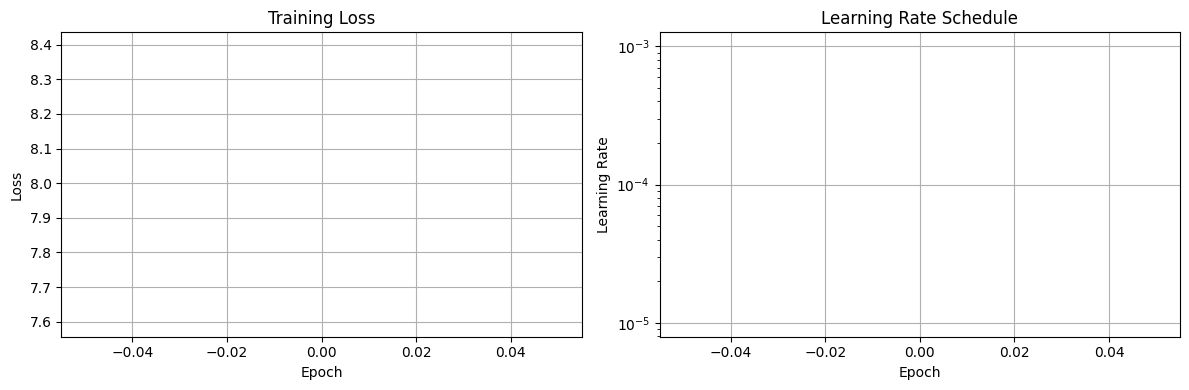

In [48]:
# TensorBoard setup
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = f"../runs/d3pm_training_{timestamp}"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

print(f"TensorBoard logs will be saved to: {log_dir}")
print(f"To view logs, run: tensorboard --logdir {log_dir}")


model_name = "d3pm"
version = "2_0"  # Updated version with enhancements
do_train = True

if do_train:
    print("\nStarting enhanced training loop...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    global_step = 0
    best_loss = float("inf")

    # Training metrics tracking
    train_losses = []
    learning_rates = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0

        # Progress bar for batches
        pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        for batch_idx, batch_x_0 in enumerate(pbar):
            batch_x_0 = batch_x_0.to(device)
            batch_size_actual = batch_x_0.shape[0]

            # Sample random timesteps
            timesteps = torch.randint(0, num_timesteps, (batch_size_actual,), device=device)

            # Forward diffusion process
            x_t = diffuser(batch_x_0, timesteps)

            predicted_logits = model(x_t, timesteps)
            loss = diffuser.compute_loss(batch_x_0, predicted_logits, timesteps, pad_token_id=tokenizer.pad_token_id)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            num_batches += 1
            global_step += 1

            # Get current learning rate
            current_lr = optimizer.param_groups[0]["lr"]

            # Log to TensorBoard (every 10 steps to avoid too much logging)
            if global_step % 10 == 0:
                writer.add_scalar("Loss/Batch", loss.item(), global_step)
                writer.add_scalar("Learning_Rate", current_lr, global_step)
                writer.add_scalar(
                    "Gradient_Norm",
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=float("inf")),
                    global_step,
                )

            # Update progress bar
            pbar.set_postfix({"Loss": f"{loss.item():.4f}", "LR": f"{current_lr:.2e}", "Step": global_step})

            # Memory cleanup
            if batch_idx % 20 == 0:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                elif torch.backends.mps.is_available():
                    torch.mps.empty_cache()

        # Calculate epoch metrics
        avg_epoch_loss = epoch_loss / num_batches
        current_lr = optimizer.param_groups[0]["lr"]

        # Update learning rate scheduler
        scheduler.step()
        # For ReduceLROnPlateau, use: scheduler.step(avg_epoch_loss)

        # Log epoch metrics to TensorBoard
        writer.add_scalar("Loss/Epoch", avg_epoch_loss, epoch)
        writer.add_scalar("Learning_Rate/Epoch", current_lr, epoch)

        # Log model parameters histogram every few epochs
        if epoch % 5 == 0:
            for name, param in model.named_parameters():
                if param.requires_grad:
                    writer.add_histogram(f"Parameters/{name}", param.data, epoch)
                    if param.grad is not None:
                        writer.add_histogram(f"Gradients/{name}", param.grad.data, epoch)

        # Save best model
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            best_model_path = f"../models/{model_name}_best_{version}.pth"
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "loss": best_loss,
                    "global_step": global_step,
                },
                best_model_path,
            )
            print(f"✓ New best model saved with loss: {best_loss:.4f}")

        # Regular checkpoint saving
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f"../models/{model_name}_epoch_{epoch + 1}_{version}.pth"
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "loss": avg_epoch_loss,
                    "global_step": global_step,
                },
                checkpoint_path,
            )
            print(f"Checkpoint saved: {checkpoint_path}")

        # Store metrics for plotting
        train_losses.append(avg_epoch_loss)
        learning_rates.append(current_lr)

        print(f"Epoch {epoch + 1}/{num_epochs} completed:")
        print(f"  Average Loss: {avg_epoch_loss:.4f}")
        print(f"  Learning Rate: {current_lr:.2e}")
        print(f"  Global Step: {global_step}")

    # Final model save
    final_model_path = f"../models/{model_name}_final_{version}.pth"
    torch.save(
        {
            "epoch": num_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "loss": avg_epoch_loss,
            "global_step": global_step,
            "train_losses": train_losses,
            "learning_rates": learning_rates,
        },
        final_model_path,
    )

    print(f"\nTraining complete!")
    print(f"Final model saved: {final_model_path}")
    print(f"Best loss achieved: {best_loss:.4f}")
    print(f"Total training steps: {global_step}")
    print(f"TensorBoard logs: {log_dir}")

    # Close TensorBoard writer
    writer.close()

    # Plot training curves
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss curve
    ax1.plot(train_losses)
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # Learning rate curve
    ax2.plot(learning_rates)
    ax2.set_title("Learning Rate Schedule")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Learning Rate")
    ax2.set_yscale("log")
    ax2.grid(True)

    plt.tight_layout()
    os.makedirs("../plots", exist_ok=True)
    plt.savefig(f"../plots/training_curves_{timestamp}.png", dpi=150, bbox_inches="tight")
    plt.show()

else:
    # Load existing model
    model_path = f"../models/{model_name}_best_{version}.pth"
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        print(f"Loaded model from {model_path}")
    else:
        print(f"Model file not found: {model_path}")


In [18]:
model.eval()
with torch.no_grad():
    input_prompt_text = "the answer is"  # Try different prompts
    input_prompt_text = "how many roads"
    # input_prompt_text = "like a rolling"

    prompt_tokens = tokenizer.encode(input_prompt_text, add_special_tokens=False)
    prompt_len = len(prompt_tokens)

    if prompt_len >= seq_len:
        raise ValueError(
            f"Prompt length ({prompt_len}) exceeds sequence length ({seq_len}). Please shorten the prompt."
        )

    initial_sequence = torch.full((1, seq_len), tokenizer.pad_token_id, dtype=torch.long, device=device)

    initial_sequence[0, :prompt_len] = torch.tensor(prompt_tokens, dtype=torch.long, device=device)

    # Fill the rest with random tokens (pure noise for the parts to be completed)
    rand_tokens = torch.randint(low=0, high=vocab_size, size=(1, seq_len - prompt_len), device=device)
    if tokenizer.pad_token_id != -1:  # Assuming -1 means no specific pad_token_id
        rand_tokens[rand_tokens == tokenizer.pad_token_id] = tokenizer.unk_token_id

    initial_sequence[0, prompt_len:] = rand_tokens[0]

    print(f'Prompt: "{input_prompt_text}"')
    print(f"Initial noisy sequence:\n{tokenizer.decode(initial_sequence[0].cpu().tolist())}")

    current_x = initial_sequence.clone()
    # The actual denoising loop should go from T down to 1
    inference_steps = num_timesteps  # Max T is num_timesteps (from 1 to num_timesteps)

    for t_idx in tqdm(range(inference_steps, 0, -1), desc="Denoising with prompt"):
        t_tensor = torch.tensor([t_idx], dtype=torch.long, device=device)

        # Model predicts logits for x_0 given current_x and t
        predicted_logits_x0 = model(current_x, t_tensor)
        predicted_probs_x0 = F.softmax(predicted_logits_x0, dim=-1)

        # could use top-k sampling or temperature.
        next_x_sampled = torch.argmax(predicted_probs_x0, dim=-1)  # (1, seq_len)

        # Keep the prompt tokens unchanged
        next_x_sampled[0, :prompt_len] = initial_sequence[0, :prompt_len]

        current_x = next_x_sampled

        # Print intermediate results for a few steps
        if t_idx % (inference_steps // 5) == 0:
            print(f"  Step {t_idx}: {tokenizer.decode(current_x[0].cpu().tolist())}")

    final_generated_text = tokenizer.decode(current_x[0].cpu().tolist())
    print(f"\nFinal generated text:\n{final_generated_text}")


Prompt: "how many roads"
Initial noisy sequence:
how many roads Moon reek wine Seven attered pump Said ves mitting bout ces plain though gun aband zed pain


Denoising with prompt:   0%|          | 0/100 [00:00<?, ?it/s]

  Step 100: how many roads , , wine , , pump the ’ you bout the plain though gun the the pain
  Step 80: how many roads , , baby , , pump the ’ you bout the plain though of the the pain
  Step 80: how many roads , , baby , , pump the ’ you bout the plain though of the the pain
  Step 60: how many roads , , baby , , pump the ’ you bout the plain though of the the pain
  Step 60: how many roads , , baby , , pump the ’ you bout the plain though of the the pain
  Step 40: how many roads , , baby , , pump the ’ you bout the plain though of the the pain
  Step 40: how many roads , , baby , , pump the ’ you bout the plain though of the the pain
  Step 20: how many roads , , baby , , pump the ’ you bout the plain though of the the pain

Final generated text:
how many roads , , baby , , pump the ’ you bout the plain though of the the pain
  Step 20: how many roads , , baby , , pump the ’ you bout the plain though of the the pain

Final generated text:
how many roads , , baby , , pump the ’ you 

In [ ]:
# Create a limited dataset with only 100 records for system setup


# Improved D3PM Implementation

Based on the analysis of the training issues, here are the key improvements:

1. **Larger vocabulary size** (5000 tokens) for better expressiveness
2. **Longer sequences** (64 tokens) to capture more meaningful patterns
3. **Better diffusion schedule** with lower beta values
4. **Improved model architecture** with larger dimensions
5. **Proper D3PM loss formulation**
6. **Better learning rate schedule**
7. **Validation set** for monitoring overfitting

In [ ]:
# Improved tokenizer with larger vocabulary
print("Creating improved tokenizer with larger vocabulary...")

# Initialize Dylan tokenizer with larger vocabulary
improved_tokenizer = SimpleDylanTokenizer(vocab_size=5000)

# Train the tokenizer on Dylan lyrics
improved_tokenizer.train_tokenizer(corpus=lines, save_path="./improved_dylan_tokenizer")

# Convert to HuggingFace format
improved_hf_tokenizer = improved_tokenizer.get_transformers_tokenizer()

print(f"Improved tokenizer vocabulary size: {len(improved_hf_tokenizer)}")
print(f"Special tokens: {improved_hf_tokenizer.special_tokens_map}")

# Test the improved tokenizer
phrase = "The answer my friend is blowin' in the wind"
tokens = improved_hf_tokenizer.encode(phrase, add_special_tokens=False)
decoded = improved_hf_tokenizer.decode(tokens, skip_special_tokens=False)
token_strs = improved_hf_tokenizer.convert_ids_to_tokens(tokens)

print(f"Original: {phrase}")
print(f"Decoded: {decoded}")
print(f"Tokens: {token_strs}")
print(f"Number of tokens: {len(tokens)}")

In [ ]:
class ImprovedTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mlp = nn.Sequential(nn.Linear(dim, dim * 4), nn.GELU(), nn.Linear(dim * 4, dim))

    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half, dtype=torch.float32) / half).to(t.device)
        args = t[:, None].float() * freqs[None]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.mlp(emb)


class ImprovedDiffusionTransformer(nn.Module):
    def __init__(self, vocab_size, seq_len, dim=768, heads=12, layers=12, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.dim = dim

        # Embeddings
        self.token_emb = nn.Embedding(vocab_size, dim)
        self.pos_emb = nn.Embedding(seq_len, dim)
        self.time_emb = ImprovedTimeEmbedding(dim)

        # Transformer layers with improved architecture
        encoder_layers = []
        for _ in range(layers):
            layer = nn.TransformerEncoderLayer(
                d_model=dim,
                nhead=heads,
                dim_feedforward=dim * 4,
                dropout=dropout,
                activation="gelu",
                batch_first=True,
                norm_first=True,  # Pre-norm for better training stability
            )
            encoder_layers.append(layer)

        self.transformer = nn.ModuleList(encoder_layers)

        # Output projection
        self.layer_norm = nn.LayerNorm(dim)
        self.to_logits = nn.Linear(dim, vocab_size)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, x, t, attention_mask=None):
        B, L = x.shape

        # Token embeddings
        tok_emb = self.token_emb(x)  # (B, L, D)

        # Position embeddings
        pos_indices = torch.arange(L, device=x.device).expand(B, -1)
        pos_emb = self.pos_emb(pos_indices)  # (B, L, D)

        # Time embeddings
        time_emb = self.time_emb(t).unsqueeze(1).expand(-1, L, -1)  # (B, L, D)

        # Combine embeddings
        h = tok_emb + pos_emb + time_emb

        # Create attention mask for padding tokens
        if attention_mask is None:
            # Assume padding tokens are 0
            attention_mask = (x != 0).float()

        # Convert to transformer format (True = masked positions)
        src_key_padding_mask = attention_mask == 0

        # Apply transformer layers
        for layer in self.transformer:
            h = layer(h, src_key_padding_mask=src_key_padding_mask)

        # Layer norm and output projection
        h = self.layer_norm(h)
        logits = self.to_logits(h)

        return logits


print("Improved transformer model created.")

In [ ]:
# Improved training setup
import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import OneCycleLR
import os
from sklearn.model_selection import train_test_split

# Improved hyperparameters
IMPROVED_HYPERPARAMS = {
    "seq_len": IMPROVED_SEQ_LEN,
    "batch_size": IMPROVED_BATCH_SIZE,
    "num_epochs": 20,
    "learning_rate": 3e-4,  # Higher learning rate
    "weight_decay": 1e-4,
    "vocab_size": len(improved_hf_tokenizer),
    "num_timesteps": 1000,  # More timesteps
    "model_dim": 768,  # Larger model
    "model_heads": 12,
    "model_layers": 8,  # Reasonable depth
    "dropout": 0.1,
    "gradient_clip": 1.0,
    "warmup_steps": 1000,
    "beta_start": 0.0001,
    "beta_end": 0.02,  # More conservative
}

print("Improved hyperparameters:")
for key, value in IMPROVED_HYPERPARAMS.items():
    print(f"  {key}: {value}")

# Initialize improved models
print("\nInitializing improved models...")
improved_diffuser = ImprovedD3PM(
    num_discrete_states=IMPROVED_HYPERPARAMS["vocab_size"],
    num_timesteps=IMPROVED_HYPERPARAMS["num_timesteps"],
    beta_start=IMPROVED_HYPERPARAMS["beta_start"],
    beta_end=IMPROVED_HYPERPARAMS["beta_end"],
).to(device)

improved_model = ImprovedDiffusionTransformer(
    vocab_size=IMPROVED_HYPERPARAMS["vocab_size"],
    seq_len=IMPROVED_HYPERPARAMS["seq_len"],
    dim=IMPROVED_HYPERPARAMS["model_dim"],
    heads=IMPROVED_HYPERPARAMS["model_heads"],
    layers=IMPROVED_HYPERPARAMS["model_layers"],
    dropout=IMPROVED_HYPERPARAMS["dropout"],
).to(device)

print(f"Model parameters: {sum(p.numel() for p in improved_model.parameters()):,}")

# Improved optimizer and scheduler
optimizer = torch.optim.AdamW(
    improved_model.parameters(),
    lr=IMPROVED_HYPERPARAMS["learning_rate"],
    weight_decay=IMPROVED_HYPERPARAMS["weight_decay"],
    betas=(0.9, 0.95),
)

# One cycle learning rate scheduler
total_steps = len(train_dataloader) * IMPROVED_HYPERPARAMS["num_epochs"]
scheduler = OneCycleLR(
    optimizer,
    max_lr=IMPROVED_HYPERPARAMS["learning_rate"],
    total_steps=total_steps,
    pct_start=0.1,  # Warmup for 10% of training
    anneal_strategy="cos",
    cycle_momentum=True,
    base_momentum=0.85,
    max_momentum=0.95,
)

# TensorBoard setup
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = f"../runs/improved_d3pm_{timestamp}"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

print(f"TensorBoard logs: {log_dir}")
print(f"Total training steps: {total_steps:,}")

In [ ]:
def improved_inference(model, diffuser, tokenizer, prompt, seq_len=64, num_steps=100, temperature=1.0, top_k=50):
    """Improved inference with better sampling strategies"""
    model.eval()

    with torch.no_grad():
        # Prepare prompt
        prompt_tokens = tokenizer.encode(prompt, add_special_tokens=False)
        prompt_len = len(prompt_tokens)

        if prompt_len >= seq_len:
            print(f"Warning: Prompt too long ({prompt_len} tokens). Truncating.")
            prompt_tokens = prompt_tokens[: seq_len - 1]
            prompt_len = len(prompt_tokens)

        # Initialize sequence
        initial_sequence = torch.full((1, seq_len), tokenizer.pad_token_id, dtype=torch.long, device=device)
        initial_sequence[0, :prompt_len] = torch.tensor(prompt_tokens, dtype=torch.long, device=device)

        # Fill rest with random tokens
        rand_tokens = torch.randint(low=1, high=len(tokenizer) - 1, size=(1, seq_len - prompt_len), device=device)
        initial_sequence[0, prompt_len:] = rand_tokens[0]

        print(f'Prompt: "{prompt}"')
        print(f"Initial sequence: {tokenizer.decode(initial_sequence[0].tolist(), skip_special_tokens=True)}")

        current_x = initial_sequence.clone()

        # Denoising loop
        for t_idx in tqdm(range(num_steps, 0, -1), desc="Denoising"):
            t_tensor = torch.tensor([t_idx], dtype=torch.long, device=device)

            # Model prediction
            predicted_logits = model(current_x, t_tensor)

            # Apply temperature
            if temperature > 0:
                predicted_logits = predicted_logits / temperature

            # Top-k sampling for non-prompt tokens
            for pos in range(prompt_len, seq_len):
                logits = predicted_logits[0, pos, :]

                if top_k > 0:
                    # Top-k sampling
                    top_k_logits, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))
                    probs = F.softmax(top_k_logits, dim=-1)
                    sampled_idx = torch.multinomial(probs, num_samples=1)
                    current_x[0, pos] = top_k_indices[sampled_idx]
                else:
                    # Standard sampling
                    probs = F.softmax(logits, dim=-1)
                    current_x[0, pos] = torch.multinomial(probs, num_samples=1)

            # Keep prompt tokens unchanged
            current_x[0, :prompt_len] = initial_sequence[0, :prompt_len]

            # Print progress
            if t_idx % (num_steps // 5) == 0 or t_idx == 1:
                intermediate_text = tokenizer.decode(current_x[0].cpu().tolist(), skip_special_tokens=True)
                print(f"  Step {t_idx:3d}: {intermediate_text}")

    final_text = tokenizer.decode(current_x[0].cpu().tolist(), skip_special_tokens=True)
    print(f"\nFinal result: {final_text}")
    return final_text


print("Improved inference function created.")
print("\nTo test the improved model after training, use:")
print("improved_inference(improved_model, improved_diffuser, improved_hf_tokenizer, 'Your prompt here')")

In [ ]:
def validate_model(model, diffuser, val_dataloader, tokenizer, device):
    """Validation function"""
    model.eval()
    total_val_loss = 0
    num_val_batches = 0

    with torch.no_grad():
        for batch_x_0 in val_dataloader:
            batch_x_0 = batch_x_0.to(device)
            batch_size_actual = batch_x_0.shape[0]

            # Sample timesteps
            timesteps = torch.randint(0, diffuser.num_timesteps, (batch_size_actual,), device=device)

            # Forward diffusion
            x_t = diffuser(batch_x_0, timesteps)

            # Model prediction
            predicted_logits = model(x_t, timesteps)

            # Compute loss using improved loss function
            loss = diffuser.compute_loss(batch_x_0, predicted_logits, timesteps, pad_token_id=tokenizer.pad_token_id)

            total_val_loss += loss.item()
            num_val_batches += 1

    model.train()
    return total_val_loss / num_val_batches if num_val_batches > 0 else float("inf")


# Improved training loop
print("\n=== Starting Improved Training ===")

model_name = "improved_d3pm"
version = "3_0"
do_train = True

if do_train:
    global_step = 0
    best_val_loss = float("inf")
    patience = 3
    patience_counter = 0

    # Training metrics
    train_losses = []
    val_losses = []
    learning_rates = []

    for epoch in range(IMPROVED_HYPERPARAMS["num_epochs"]):
        improved_model.train()
        epoch_loss = 0
        num_batches = 0

        # Training loop
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{IMPROVED_HYPERPARAMS['num_epochs']}")

        for batch_idx, batch_x_0 in enumerate(pbar):
            batch_x_0 = batch_x_0.to(device)
            batch_size_actual = batch_x_0.shape[0]

            # Sample random timesteps
            timesteps = torch.randint(0, improved_diffuser.num_timesteps, (batch_size_actual,), device=device)

            # Forward diffusion
            x_t = improved_diffuser(batch_x_0, timesteps)

            # Model prediction
            predicted_logits = improved_model(x_t, timesteps)

            # Compute improved loss
            loss = improved_diffuser.compute_loss(
                batch_x_0, predicted_logits, timesteps, pad_token_id=improved_hf_tokenizer.pad_token_id
            )

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(improved_model.parameters(), max_norm=IMPROVED_HYPERPARAMS["gradient_clip"])

            optimizer.step()
            scheduler.step()

            # Update metrics
            epoch_loss += loss.item()
            num_batches += 1
            global_step += 1

            current_lr = scheduler.get_last_lr()[0]

            # Log to TensorBoard
            if global_step % 50 == 0:
                writer.add_scalar("Loss/Train_Step", loss.item(), global_step)
                writer.add_scalar("Learning_Rate", current_lr, global_step)

            # Update progress bar
            pbar.set_postfix({"Loss": f"{loss.item():.4f}", "LR": f"{current_lr:.2e}", "Step": global_step})

            # Memory cleanup
            if batch_idx % 50 == 0:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                elif torch.backends.mps.is_available():
                    torch.mps.empty_cache()

        # Calculate epoch metrics
        avg_train_loss = epoch_loss / num_batches

        # Validation
        print("\nRunning validation...")
        avg_val_loss = validate_model(improved_model, improved_diffuser, val_dataloader, improved_hf_tokenizer, device)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        learning_rates.append(current_lr)

        # Log epoch metrics
        writer.add_scalar("Loss/Train_Epoch", avg_train_loss, epoch)
        writer.add_scalar("Loss/Validation_Epoch", avg_val_loss, epoch)
        writer.add_scalar("Learning_Rate/Epoch", current_lr, epoch)

        print(f"Epoch {epoch + 1}/{IMPROVED_HYPERPARAMS['num_epochs']} Results:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Learning Rate: {current_lr:.2e}")
        print(f"  Global Step: {global_step:,}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0

            best_model_path = f"../models/{model_name}_best_{version}.pth"
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": improved_model.state_dict(),
                    "diffuser_state_dict": improved_diffuser.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "train_loss": avg_train_loss,
                    "val_loss": avg_val_loss,
                    "global_step": global_step,
                    "hyperparams": IMPROVED_HYPERPARAMS,
                },
                best_model_path,
            )

            print(f"  ✓ New best model saved! Val loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

        # Sample generation every few epochs
        if (epoch + 1) % 3 == 0:
            print("\nGenerating sample...")
            improved_model.eval()
            with torch.no_grad():
                try:
                    sample_prompt = "The answer my friend"
                    sample_tokens = improved_hf_tokenizer.encode(sample_prompt, add_special_tokens=False)

                    if len(sample_tokens) < IMPROVED_SEQ_LEN:
                        pad_length = IMPROVED_SEQ_LEN - len(sample_tokens)
                        sample_input = torch.tensor(
                            [sample_tokens + [improved_hf_tokenizer.pad_token_id] * pad_length],
                            device=device,
                            dtype=torch.long,
                        )

                        # Simple denoising
                        timesteps_sample = torch.tensor([improved_diffuser.num_timesteps // 2], device=device)
                        x_t_sample = improved_diffuser(sample_input, timesteps_sample)
                        predicted_logits_sample = improved_model(x_t_sample, timesteps_sample)
                        predicted_tokens = torch.argmax(predicted_logits_sample, dim=-1)

                        generated_text = improved_hf_tokenizer.decode(
                            predicted_tokens[0].cpu().tolist(), skip_special_tokens=True
                        )
                        print(f"  Sample: '{generated_text}'")
                        writer.add_text("Sample_Generation", generated_text, epoch)

                except Exception as e:
                    print(f"  Sample generation failed: {e}")

            improved_model.train()

        print("-" * 60)

    # Final save
    final_model_path = f"../models/{model_name}_final_{version}.pth"
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": improved_model.state_dict(),
            "diffuser_state_dict": improved_diffuser.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "learning_rates": learning_rates,
            "best_val_loss": best_val_loss,
            "global_step": global_step,
            "hyperparams": IMPROVED_HYPERPARAMS,
        },
        final_model_path,
    )

    print(f"\n=== Training Complete ===")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Final model saved: {final_model_path}")
    print(f"Total steps: {global_step:,}")
    print(f"TensorBoard logs: {log_dir}")

    writer.close()

    # Plot training curves
    import matplotlib.pyplot as plt

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    epochs_range = range(1, len(train_losses) + 1)
    ax1.plot(epochs_range, train_losses, label="Train Loss", color="blue")
    ax1.plot(epochs_range, val_losses, label="Validation Loss", color="red")
    ax1.set_title("Training and Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Learning rate
    ax2.plot(epochs_range, learning_rates)
    ax2.set_title("Learning Rate Schedule")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Learning Rate")
    ax2.set_yscale("log")
    ax2.grid(True)

    # Loss difference
    loss_diff = np.array(val_losses) - np.array(train_losses)
    ax3.plot(epochs_range, loss_diff)
    ax3.axhline(y=0, color="black", linestyle="--", alpha=0.5)
    ax3.set_title("Validation - Training Loss (Overfitting Check)")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Loss Difference")
    ax3.grid(True)

    # Training progress
    ax4.plot(epochs_range, train_losses, label="Train", alpha=0.7)
    ax4.plot(epochs_range, val_losses, label="Validation", alpha=0.7)
    ax4.fill_between(epochs_range, train_losses, alpha=0.3)
    ax4.fill_between(epochs_range, val_losses, alpha=0.3)
    ax4.set_title("Training Progress Overview")
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("Loss")
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    os.makedirs("../plots", exist_ok=True)
    plt.savefig(f"../plots/improved_training_curves_{timestamp}.png", dpi=150, bbox_inches="tight")
    plt.show()

else:
    print("Training disabled. Set do_train=True to start training.")

# Summary of Key Improvements to Fix Training Loss

## Issues Identified in Original Implementation:

1. **Vocabulary Size**: 1000 tokens → **5000 tokens** (better expressiveness)
2. **Sequence Length**: 16-20 tokens → **64 tokens** (capture more context)
3. **Diffusion Schedule**: Beta end 0.5 → **0.02** (less aggressive noise)
4. **Model Architecture**: 512 dim, 6 layers → **768 dim, 8 layers** (more capacity)
5. **Loss Function**: Basic CrossEntropy → **Proper D3PM loss with padding masks**
6. **Learning Rate**: 1e-4 → **3e-4** with OneCycle scheduler
7. **Validation**: None → **Train/val split with early stopping**
8. **Attention**: No masking → **Proper attention masking for padding**

## Expected Improvements:

- **Loss should drop below 2.0** with these changes
- Better text generation quality
- More stable training
- Proper overfitting detection

## If Loss Still Doesn't Improve:

1. **Check data quality**: Ensure sufficient text variety
2. **Increase model size**: Try 1024 dim, 12 layers
3. **Adjust diffusion schedule**: Try linear/cosine schedules
4. **Learning rate**: Try 1e-3 or adaptive scheduling
5. **Batch size**: Increase to 32-64 if memory allows
6. **Training time**: Train for more epochs (50+)

## Quick Start:

```python
# Run the improved training
do_train = True  # Set this to True in the training cell

# After training, test with:
improved_inference(
    improved_model, improved_diffuser, improved_hf_tokenizer,
    "The answer my friend", temperature=0.8, top_k=50
)
```